In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from acquire import get_connection, new_telco_churn_data, get_telco_churn_data
from env import username, host, password

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from acquire import get_connection, new_telco_churn_data, get_telco_churn_data
from prepare import num_distributions, clean_telco_churn, telco_churn_split, prep_telco_churn

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics

from math import sqrt
from scipy import stats

In [2]:
def get_metrics_binary(clf):
    '''
    get_metrics_binary takes in a confusion matrix (cnf) for a binary classifier and prints out metrics based on
    values in variables named X_train, y_train, and y_pred.
    
    return: a classification report as a transposed DataFrame
    '''
    accuracy = clf.score(X_train, y_train)
    class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
    conf = confusion_matrix(y_train, y_pred)
    tpr = conf[1][1] / conf[1].sum()
    fpr = conf[0][1] / conf[0].sum()
    tnr = conf[0][0] / conf[0].sum()
    fnr = conf[1][0] / conf[1].sum()
    print(f'''
    The accuracy for our model is {accuracy:.4}
    The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
    The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
    ''')
    return class_report

In [ ]:
a = 0.05

In [ ]:
df = get_telco_churn_data()
df.tail()

In [ ]:
observed = pd.crosstab(df.churn, df.payment_type)
observed

In [ ]:
chi2, p ,degf, expected = stats.chi2_contingency(observed)
chi2, p

In [ ]:
if p < a:
    print("Reject null hypothesis, payment type and churn are not independent")
else:
    print("Fail to reject null hypothesis, payment type and churn are independent, let's keep finding features that are not.")

In [ ]:
sns.countplot(x="payment_type", hue="churn", data=df)

Most payment types are very consistent between the number of people who churn and don't churn. However, electronic check users have a very high churn rate.

In [ ]:
a = 0.05

In [ ]:
observed = pd.crosstab(df.churn, df.paperless_billing)
observed

In [ ]:
chi2, p ,degf, expected = stats.chi2_contingency(observed)
chi2, p

In [ ]:
if p < a:
    print("Reject null hypothesis, paperless billing and churn are not independent")
else:
    print("Fail to reject null hypothesis, paperless billing and churn are independent, let's keep finding features that are not.")

In [ ]:
sns.countplot(x="paperless_billing", hue="churn", data=df)

I am finding that customers who use paperless billing and customers who churn have significant overlap. These groups are not independent. For customers who use paperless billing, a lot of them churn compared to people who don't use automated payments. 

In [ ]:
observed = pd.crosstab(df.churn, df.internet_service_type)
observed

In [ ]:
chi2, p ,degf, expected = stats.chi2_contingency(observed)
chi2, p

In [ ]:
if p < a:
    print("Reject null hypothesis, internet type and churn are not independent")
else:
    print("Fail to reject null hypothesis, internet type and churn are independent, let's keep finding features that are not.")

In [ ]:
dsl = df[df.internet_service_type =="DSL"].monthly_charges
fiber_optic = df[df.internet_service_type=="Fiber optic"].monthly_charges

In [ ]:
dsl.hist()

In [ ]:
fiber_optic.hist()

In [ ]:
dsl.var(),fiber_optic.var()

In [ ]:
t,p= stats.ttest_ind(dsl, fiber_optic, equal_var = False)
t, p/2, a

In [ ]:
sns.countplot(x='churn', data = df)

In [ ]:
sns.countplot(x="churn", hue="internet_service_type", data=df)

In [ ]:
sns.countplot(x="internet_service_type", hue="churn", data=df)

In [ ]:
fiber_optic.head()

In [ ]:
#bring in clean data, drop columns we're not using, then split and stratify by churn. 

In [7]:
def split(df, stratify_by=None):
    """
    Crude train, validate, test split
    To stratify, send in a column name for the stratify_by argument
    """

    if stratify_by == None:
        train, test = train_test_split(df, test_size=.2, random_state=123)
        train, validate = train_test_split(train, test_size=.3, random_state=123)
    else:
        train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df[stratify_by])
        train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train[stratify_by])

    return train, validate, test

In [8]:
df = get_telco_churn_data()
train, validate, test = prep_telco_churn(df)

In [9]:
x_col = ['fiber_optic', 'electronic_check', 'monthly_charges', 'tenure', 'two_year', 'monthly']
y_col = 'churn'

In [10]:
train.shape, validate.shape, test.shape

((3943, 27), (1691, 27), (1409, 27))

In [11]:
train.head()

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,dsl,fiber_optic,no_internet,monthly,one_year,two_year,bank_transfer,credit_card,electronic_check,mailed_check
5707,1,1,0,72,1,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
4471,0,1,1,56,1,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
4994,1,0,0,60,1,1,1,1,0,0,...,1,0,0,0,1,0,0,0,1,0
3458,1,1,0,25,1,1,1,0,0,1,...,1,0,0,1,0,0,0,1,0,0
3818,0,0,0,20,1,1,1,0,0,1,...,1,0,0,1,0,0,1,0,0,0


In [12]:
X_train, y_train = train[x_col], train[y_col]

X_validate, y_validate = validate[x_col], validate[y_col]

X_test, y_test = test[x_col], validate[y_col]

In [7]:
X_train.head()

,fiber_optic,electronic_check,monthly_charges,tenure,two_year
5707,0,0,25.00,72,1
4471,1,0,88.90,56,0
4994,0,1,71.75,60,0
3458,0,0,69.50,25,0
3818,0,0,59.20,20,0


In [ ]:
y_train.value_counts()

In [8]:
train['baseline_prediction'] = 0 #because I'm predicting more people did NOT churn
round(accuracy_score(train.churn, train.baseline_prediction),2)

0.73

In [9]:
baseline_score = round(accuracy_score(train.churn, train.baseline_prediction),2)

In [10]:
#accuracy score is 73.4%

# Model Creations

### Decision Trees (Tree3 is the best)

In [3]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

In [53]:
tree1 = DecisionTreeClassifier(max_leaf_nodes=15, max_depth=2)

In [54]:
tree1.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=15)

In [55]:
print(f'training score: {tree1.score(X_train, y_train):.2%}')
print(f'validate score: {tree1.score(X_validate, y_validate):.2%}')

training score: 79.53%
validate score: 78.06%


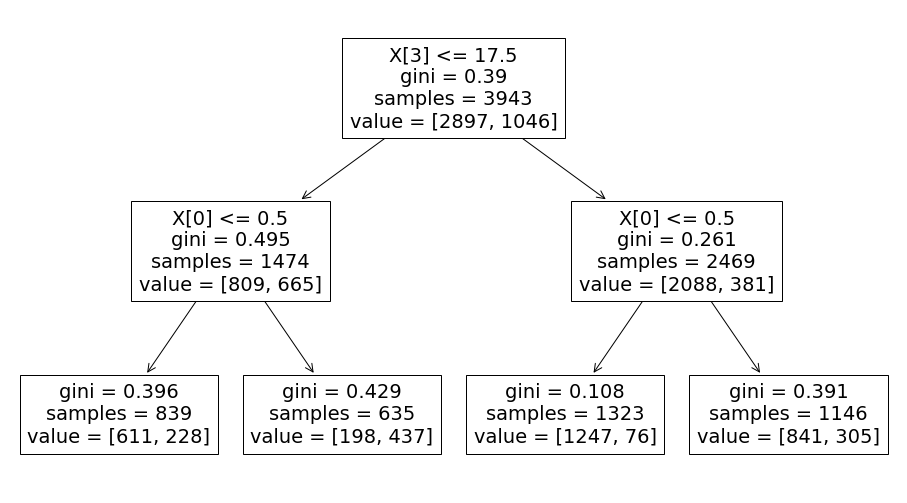

In [83]:
plt.figure(figsize=(16,9))
plot_tree(tree1)
plt.show()

In [148]:
y_pred = tree1.predict(X_train)

In [150]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2897
           1       0.69      0.42      0.52      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.67      0.69      3943
weighted avg       0.78      0.80      0.78      3943



In [19]:
tree2 = DecisionTreeClassifier(max_leaf_nodes=20, max_depth=15)

In [20]:
tree2.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=15, max_leaf_nodes=20)

In [21]:
print(f'training score: {tree2.score(X_train, y_train):.2%}')
print(f'validate score: {tree2.score(X_validate, y_validate):.2%}')

training score: 80.85%
validate score: 77.23%


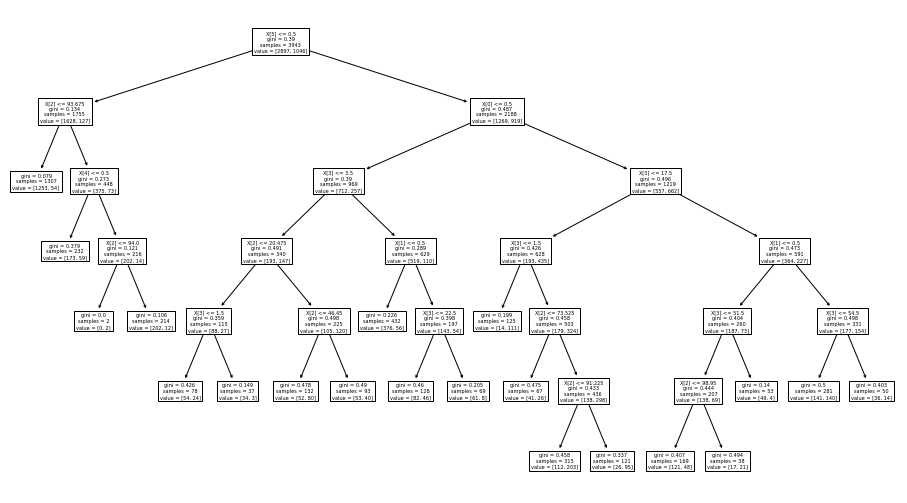

In [16]:
plt.figure(figsize=(16,9))
plot_tree(tree2)
plt.show()

In [17]:
y_pred = tree2.predict(X_train)

In [18]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.88      2897
           1       0.70      0.49      0.58      1046

    accuracy                           0.81      3943
   macro avg       0.77      0.71      0.73      3943
weighted avg       0.80      0.81      0.80      3943



In [22]:
tree3 = DecisionTreeClassifier(max_leaf_nodes=15, max_depth=5)

In [23]:
tree3.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=15)

In [24]:
print(f'training score: {tree3.score(X_train, y_train):.2%}')
print(f'validate score: {tree3.score(X_validate, y_validate):.2%}')

training score: 80.37%
validate score: 78.42%


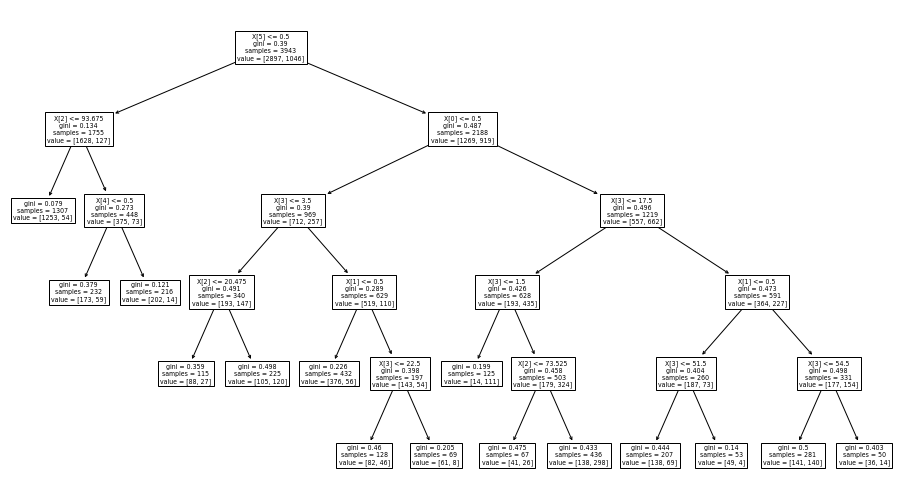

In [23]:
plt.figure(figsize=(16,9))
plot_tree(tree3)
plt.show()

In [28]:
print(f'recall score is {sklearn.metrics.recall_score(y_train, y_pred, pos_label =0)}')

recall score is 0.9112875388332758


In [27]:
y_pred = tree3.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      2897
           1       0.67      0.51      0.58      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.71      0.72      3943
weighted avg       0.79      0.80      0.79      3943



In [31]:
print(f'precision score is {sklearn.metrics.precision_score(y_train, y_pred, pos_label =0)}')

precision score is 0.8362369337979094


In [239]:
get_metrics_binary(tree3)


    The accuracy for our model is 0.805
    The True Positive Rate is 0.486, The False Positive Rate is 0.0307,
    The True Negative Rate is 0.969, and the False Negative Rate is 0.514
    


,precision,recall,f1-score,support
0,0.839211,0.969279,0.899568,2897.000000
1,0.850921,0.485660,0.618381,1046.000000
accuracy,0.840984,0.840984,0.840984,0.840984
macro avg,0.845066,0.727469,0.758974,3943.000000
weighted avg,0.842318,0.840984,0.824974,3943.000000


In [142]:
tree4 = DecisionTreeClassifier(max_leaf_nodes=2, max_depth=2)

In [143]:
tree4.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=2)

In [144]:
print(f'training score: {tree4.score(X_train, y_train):.2%}')
print(f'validate score: {tree4.score(X_validate, y_validate):.2%}')

training score: 73.47%
validate score: 73.45%


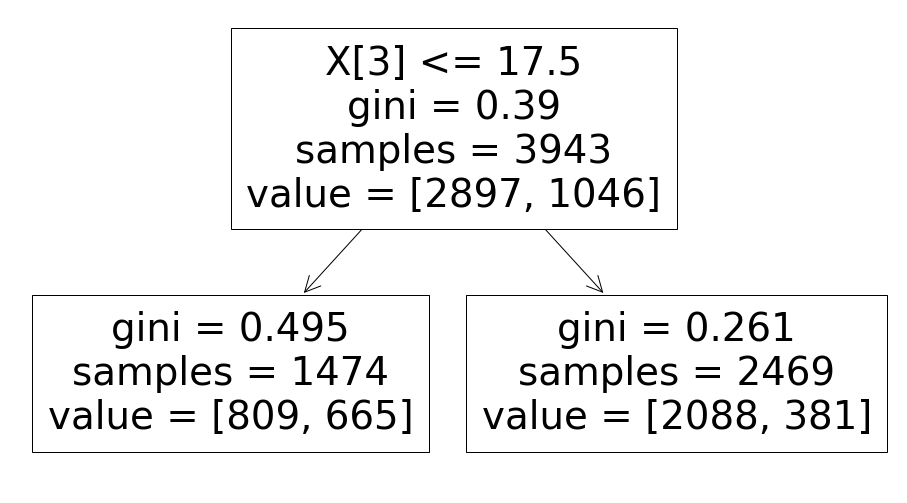

In [145]:
plt.figure(figsize=(16,9))
plot_tree(tree4)
plt.show()

In [156]:
y_pred = tree4.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      2897
           1       0.00      0.00      0.00      1046

    accuracy                           0.73      3943
   macro avg       0.37      0.50      0.42      3943
weighted avg       0.54      0.73      0.62      3943



/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [157]:
print(f'recall score is {sklearn.metrics.recall_score(y_train, y_pred)}')

recall score is 0.0


## KNN (knn2 is the best)

In [146]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, minmax_scale

In [235]:
knn1 = KNeighborsClassifier(n_neighbors=4)
knn1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [236]:
y_pred = knn1.predict(X_train)
y_pred_proba = knn1.predict_proba(X_train)

In [237]:
#model score
round(knn1.score(X_train,y_train),2)

0.84

In [161]:
print(f'training score: {knn1.score(X_train, y_train):.2%}')
print(f'validate score: {knn1.score(X_validate, y_validate):.2%}')

training score: 84.10%
validate score: 76.88%


In [162]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2897
           1       0.85      0.49      0.62      1046

    accuracy                           0.84      3943
   macro avg       0.85      0.73      0.76      3943
weighted avg       0.84      0.84      0.82      3943



In [201]:
knn2 = KNeighborsClassifier(n_neighbors = 10)
knn2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [202]:
y_pred = knn2.predict(X_train)
y_pred_proba = knn2.predict_proba(X_train)

In [203]:
print(f'training score: {knn2.score(X_train, y_train):.2%}')
print(f'validate score: {knn2.score(X_validate, y_validate):.2%}')

training score: 81.77%
validate score: 78.42%


In [204]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.88      2897
           1       0.73      0.49      0.59      1046

    accuracy                           0.82      3943
   macro avg       0.78      0.71      0.74      3943
weighted avg       0.81      0.82      0.80      3943



In [240]:
get_metrics_binary(knn2)


    The accuracy for our model is 0.8177
    The True Positive Rate is 0.486, The False Positive Rate is 0.0307,
    The True Negative Rate is 0.969, and the False Negative Rate is 0.514
    


,precision,recall,f1-score,support
0,0.839211,0.969279,0.899568,2897.000000
1,0.850921,0.485660,0.618381,1046.000000
accuracy,0.840984,0.840984,0.840984,0.840984
macro avg,0.845066,0.727469,0.758974,3943.000000
weighted avg,0.842318,0.840984,0.824974,3943.000000


In [205]:
knn3 = KNeighborsClassifier(n_neighbors = 50)
knn3.fit(X_train, y_train)
y_pred = knn3.predict(X_train)
y_pred_proba = knn3.predict_proba(X_train)
print(f'training score: {knn3.score(X_train, y_train):.2%}')
print(f'validate score: {knn3.score(X_validate, y_validate):.2%}')

training score: 80.24%
validate score: 78.36%


In [206]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2897
           1       0.71      0.44      0.54      1046

    accuracy                           0.80      3943
   macro avg       0.76      0.69      0.71      3943
weighted avg       0.79      0.80      0.79      3943



In [208]:
knn4 = KNeighborsClassifier(n_neighbors = 100)
knn4.fit(X_train, y_train)
y_pred = knn4.predict(X_train)
y_pred_proba = knn4.predict_proba(X_train)
print(f'training score: {knn4.score(X_train, y_train):.2%}')
print(f'validate score: {knn4.score(X_validate, y_validate):.2%}')

training score: 79.81%
validate score: 78.65%


In [209]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2897
           1       0.70      0.42      0.52      1046

    accuracy                           0.80      3943
   macro avg       0.76      0.68      0.70      3943
weighted avg       0.79      0.80      0.78      3943



## Logistic Regression

In [183]:
from sklearn.linear_model import LogisticRegression

In [211]:
logit1 = LogisticRegression(random_state =123)
logit1.fit(X_train, y_train)
y_pred = logit1.predict(X_train)
print(f'training score: {logit1.score(X_train, y_train):.2%}')
print(f'validate score: {logit1.score(X_validate, y_validate):.2%}')

training score: 79.66%
validate score: 78.36%


In [212]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2897
           1       0.66      0.49      0.56      1046

    accuracy                           0.80      3943
   macro avg       0.74      0.70      0.71      3943
weighted avg       0.78      0.80      0.79      3943



In [214]:
logit2 = LogisticRegression(C= 10, random_state =123)
logit2.fit(X_train, y_train)
y_pred = logit2.predict(X_train)
print(f'training score: {logit2.score(X_train, y_train):.2%}')
print(f'validate score: {logit2.score(X_validate, y_validate):.2%}')

training score: 79.63%
validate score: 78.42%


In [215]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2897
           1       0.66      0.49      0.56      1046

    accuracy                           0.80      3943
   macro avg       0.74      0.70      0.71      3943
weighted avg       0.78      0.80      0.79      3943



In [220]:
logit3 = LogisticRegression(C= 50, random_state =123)
logit3.fit(X_train, y_train)
y_pred = logit3.predict(X_train)
print(f'training score: {logit3.score(X_train, y_train):.2%}')
print(f'validate score: {logit3.score(X_validate, y_validate):.2%}')

training score: 79.58%
validate score: 78.42%


In [221]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2897
           1       0.66      0.49      0.56      1046

    accuracy                           0.80      3943
   macro avg       0.74      0.70      0.71      3943
weighted avg       0.78      0.80      0.79      3943



In [222]:
logit4 = LogisticRegression(class_weight =dict,random_state =1349)
logit4.fit(X_train, y_train)
y_pred = logit4.predict(X_train)
print(f'training score: {logit4.score(X_train, y_train):.2%}')
print(f'validate score: {logit4.score(X_validate, y_validate):.2%}')

training score: 79.66%
validate score: 78.36%


In [223]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2897
           1       0.66      0.49      0.56      1046

    accuracy                           0.80      3943
   macro avg       0.74      0.70      0.71      3943
weighted avg       0.78      0.80      0.79      3943



In [229]:
get_metrics_binary(logit4)


    The accuracy for our model is 0.7966
    The True Positive Rate is 0.486, The False Positive Rate is 0.0911,
    The True Negative Rate is 0.909, and the False Negative Rate is 0.514
    


,precision,recall,f1-score,support
0,0.830337,0.908871,0.867831,2897.000000
1,0.658031,0.485660,0.558856,1046.000000
accuracy,0.796602,0.796602,0.796602,0.796602
macro avg,0.744184,0.697265,0.713344,3943.000000
weighted avg,0.784628,0.796602,0.785866,3943.000000
